# Nubank 

# Account Monthly Balance

---

 1. Create a SQL file to help Jane retrieving the monthly balance of all accounts (this query should be made using the warehouse structure before the changes you propose on 2.)

The process for *Account Monthly Balance*

```SQL
with customer as (
	select distinct customer_id,
		first_name,
		last_name
	from "nubankdb"."customers"
), --- Table with customer information 
accounts as (
	select distinct account_id,
		customer_id
	from "nubankdb"."accounts" 
	where status = 'active'
), --- Table with accounts information (join with customer)
time as(
select intrans.account_id,
    monthdb.action_month
from (
		select account_id,
			amount as in_amount,
			0 as out_amount,
			transaction_completed_at,
			month(
				from_unixtime(cast(transaction_completed_at as bigint) / 1000)
			) as month_1
		from "nubankdb"."intrans"
		where status = 'completed'
	) as intrans --- Transactions as baseline
	left join (
		select time_id,
			month_id
		from "nubankdb"."d_time"
	) as time on time.time_id = intrans.transaction_completed_at --- month_id
	left join(select month_id,
			action_month
		from "nubankdb"."d_month"
	) as monthdb on time.month_id = monthdb.month_id --- action_month
), --- Table to extract month and compare to unixtime (Same)
trans as(
	select account_id,
		month,
		sum(in_amount) as intrans,
		sum(out_amount) as outtrans,
		sum(in_amount) - sum(out_amount)  as Account_Monthly_Balance
	from (
			select account_id,
				amount as in_amount,
				0 as out_amount,
				month(
					from_unixtime(cast(transaction_completed_at as bigint) / 1000)
				) as month
			from "nubankdb"."intrans"
			where status = 'completed' --- Only completed actions will be taken
			union all
			select account_id,
				0 as in_amount,
				amount as out_amount,
				month(
					from_unixtime(cast(transaction_completed_at as bigint) / 1000)
				) as month
			from "nubankdb"."outtrans"
			where status = 'completed' --- Only completed actions will be taken out transfers
			union all
			select account_id,
				case --- out transfers based on in pix transactions
					in_or_out
					when 'pix_in' then cast(pix_amount as double) else 0
				end as in_amount,
				case --- out transfers based on out pix transactions
					in_or_out
					when 'pix_out' then cast(pix_amount as double) else 0
				end as out_amount,
				month(
					from_unixtime(cast(pix_completed_at as bigint) / 1000)
				) as month
			from "nubankdb"."pix_mov"
			where status = 'completed' --- Only completed
		)
	group by account_id,
		month
)
select trans.month,
	accounts.customer_id,
	customer.first_name,
	customer.last_name,
	trans.intrans,
	trans.outtrans,
	trans.Account_Monthly_Balance
from accounts
	right join trans on accounts.account_id = trans.account_id --- Accounts -> Transactions
	left join customer on customer.customer_id = accounts.customer_id --- Customers -> accounts
group by trans.month,
	trans.month,
	accounts.customer_id,
	customer.first_name,
	customer.last_name,
	trans.intrans,
	trans.outtrans,
	trans.Account_Monthly_Balance
```


## Explaination through Diagram

In [ ]:
# diagram.py
from diagrams import Cluster, Diagram
from diagrams.aws.compute import ECS, EKS, Lambda
from diagrams.gcp.analytics import BigQuery, Dataflow, PubSub
from diagrams.gcp.compute import AppEngine, Functions
from diagrams.aws.database import Redshift
from diagrams.aws.integration import SQS
from diagrams.aws.storage import S3
from diagrams.onprem.compute import Server
from diagrams.aws.database import Aurora
from urllib.request import urlretrieve
from diagrams.custom import Custom

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/' ## Path for graphics

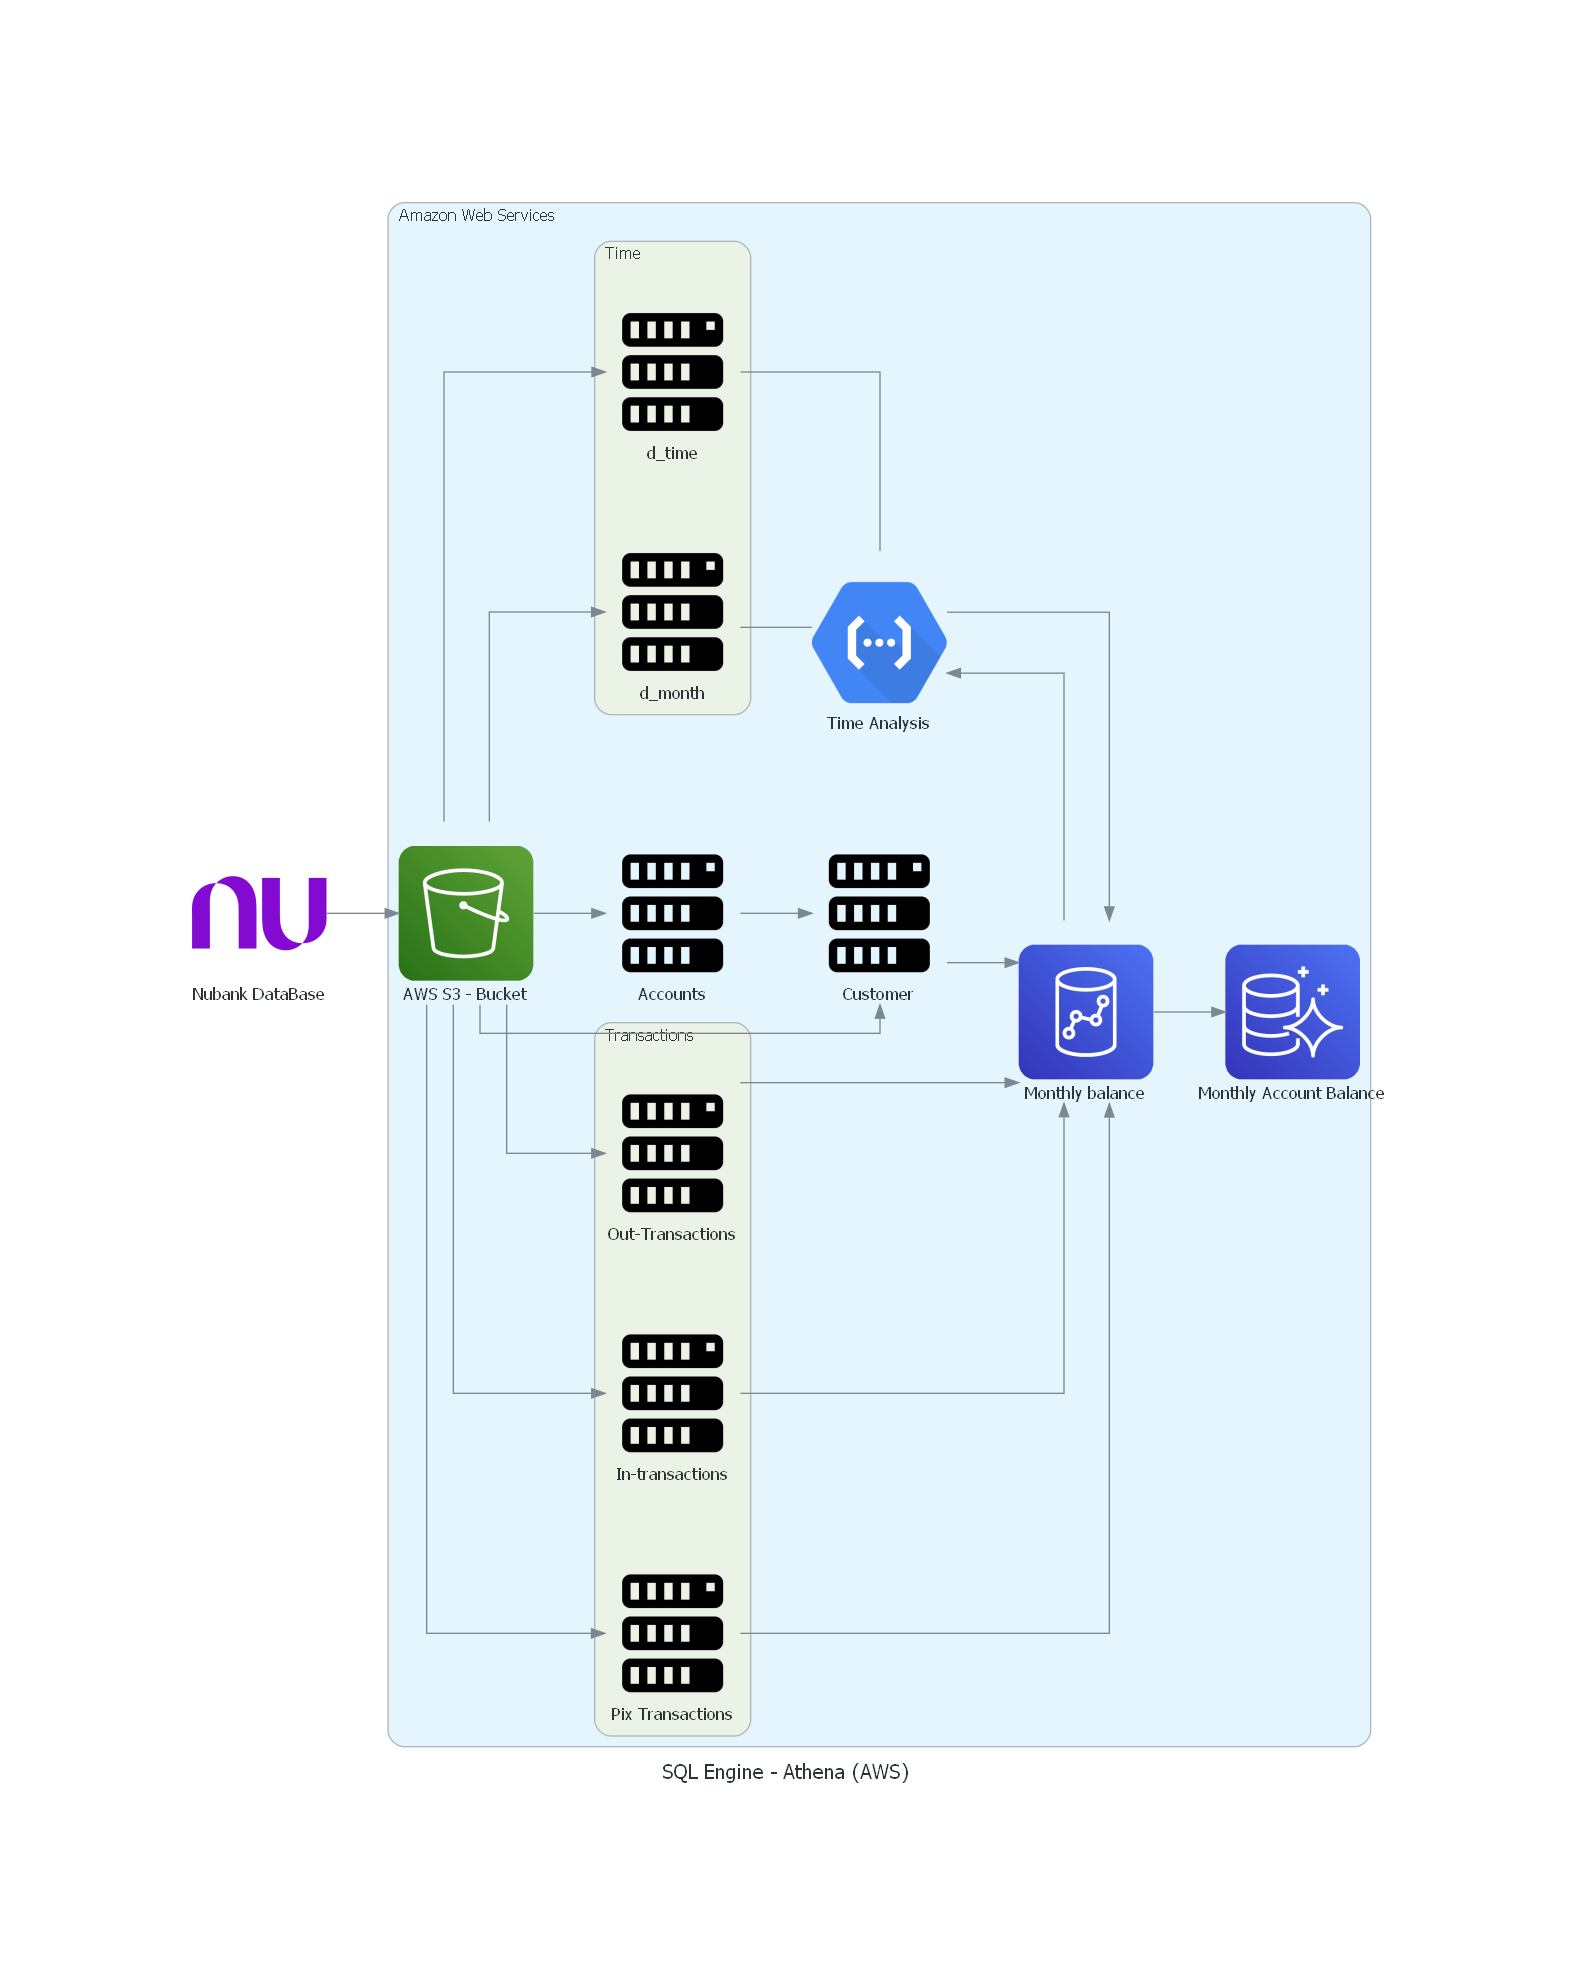

In [21]:
## Add Nubank icon as first image

nubank_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f7/Nubank_logo_2021.svg/800px-Nubank_logo_2021.svg.png"
nubank_icon = "nubank.png"
urlretrieve(nubank_url, nubank_icon)

## Diagram structure

with Diagram("SQL Engine - Athena (AWS)", show = False) as diag:
    queue = Custom("Nubank DataBase", nubank_icon)
    with Cluster("Amazon Web Services"): ## Global AWS (Athena)
        store = S3("AWS S3 - Bucket") ## Bucket - Storage
        queue >> store
        with Cluster("Transactions"):  ## Transactions
            grpcsvc = [
                Server("Pix Transactions"),
                Server("In-transactions"),
                Server("Out-Transactions")]
            store >> grpcsvc
        dw = Redshift("Monthly balance")  ## Monthly balance
        grpcsvc >> dw
        Accounts = Server("Accounts")  ## Accounts
        store >> Accounts
        Customer = Server("Customer")  ## Customers
        store >> Customer
        with Cluster("Time"):  ## Time data
            time = [
                Server("d_time"),
                Server("d_month")]
            store >> time
        
        time_analysis = Functions("Time Analysis")
        merge_time = [time - time_analysis << dw]
        
        AMB = Accounts >> Customer >> dw  ## Cross tables
        
        time_analysis >> AMB >> Aurora("Monthly Account Balance")  ## Final result

diag

# Data Warehouse Architecture

---

2. Improve the data warehouse architecture and justify your changes

In [22]:
# diagram.py
from diagrams import Cluster, Diagram
from diagrams.gcp.compute import AppEngine, Functions
from diagrams.gcp.storage import GCS
from diagrams.gcp.database import BigTable

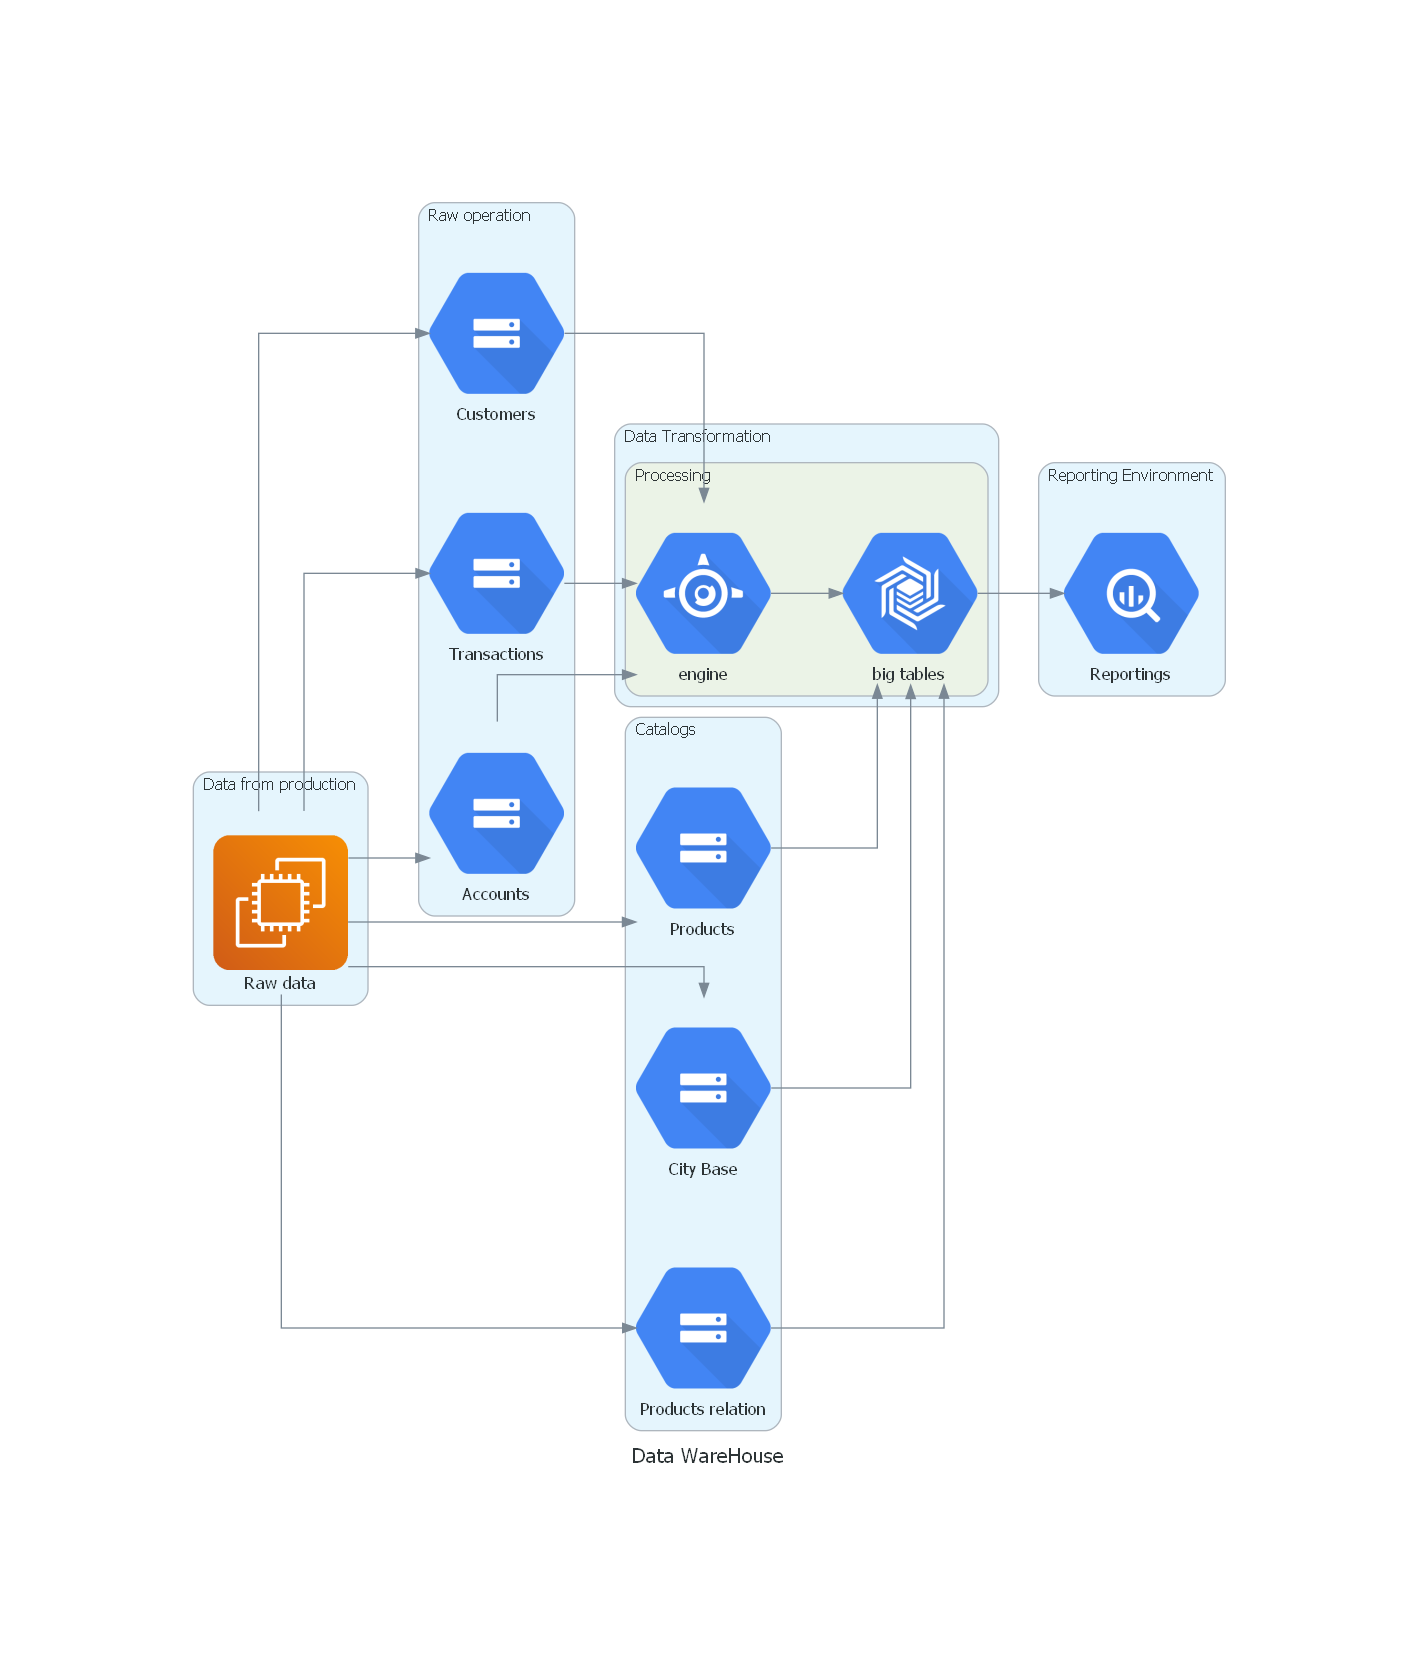

In [39]:
with Diagram("Data WareHouse", show = False) as diag:
    with Cluster("Data from production"):
        services=EC2("Raw data")
        
    with Cluster("Raw operation"):
        data = [GCS("Customers"),
                GCS("Transactions"),
                GCS("Accounts")]
        services >> data
    
    with Cluster("Catalogs"):
        cat = [GCS("Products"),
                GCS("City Base"),
              GCS("Products relation")]
        services >> cat 
        
    with Cluster("Data Transformation"):
            with Cluster("Processing"):
                process = AppEngine("engine")
                table = BigTable("big tables")
                data >> process
                process >> table
                cat >> table
                
    with Cluster("Reporting Environment"):
        reports=BigQuery("Reportings")
        table >> reports
              
diag

In [44]:
import plotly.graph_objects as go

values = [['Customer information', 'Accounts information', 'Transaction information', 'Product catalog', 'Georeferencial catalog', 'product relation'], #1st col
  ["Table that contains sensible and relevant information of the client. No product or account related. This table should have socio-economic information to ease customer detailed access in history. Partition by Country and date",
  " Information related to client's accounts (Clients must repeat as many as accounts they have). Focused on relevant information like status, branch, creation. This lets the analyst cluster accounts information in countries, status and time. Partition by Country and date.",
  "All transactions with linkeable information from customers and accounts. It must provide information of pix/no pix transaction, as well as status, amount, among other. Financial information with no additional information, accessed eased by customer and accounts",
  "Account and product information, id, country and additional information aiming the estandarized and centralized countries products",
  "Country, cities and counties for every country, both name and id. By adding this information the analysts would be able to identify by regional understanding the growth, impact, savings, possible regional strategies.",
  "To ease deep dive understanding by product Vs customer, this table provides no transactions but initial conditions of the product. This helps to see by product by date activity and status"]]


fig = go.Figure(data=[go.Table(
  columnorder = [1,2],
  columnwidth = [80,400],
  header = dict(
    values = [['<b>DATA WAREHOUSE</b><br>Global dataset'],
                  ['<b>DESCRIPTION</b>']],
    line_color='darkslategray',
    fill_color='lightsteelblue',
    align=['left','center'],
    font=dict(color='black', size=12),
    height=30
  ),
  cells=dict(
    values=values,
    line_color='black',
    fill=dict(color=['lavenderblush', 'white']),
    align=['left', 'center'],
    font_size=11,
    height=30)
    )
])
fig.show()

# Timeline execution plan

---

**Agregar imagen de Google con las tablas y procesos para mejor entendimiento**

# PIX KPIs

---

**Agregar imagen de Google con las tablas y procesos para mejor entendimiento**